Food-101 Nutrition Database Creation
-----------------------------------
This notebook creates a mapping from Food-101 food classes to nutritional information.


In [22]:
import pandas as pd
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Create directories for saving data
os.makedirs("../nutrition_data", exist_ok=True)

# Load Food-101 dataset
food101_df = pd.read_pickle("../data/food101_df.pkl")
unique_foods = sorted(food101_df['label'].unique())
print(f"Found {len(unique_foods)} unique food classes in Food-101")


Found 101 unique food classes in Food-101


In [23]:
# Manual nutrition data for common foods in Food-101
manual_nutrition_data = {
    "apple_pie": {"protein": 3.6, "carbohydrates": 34.0, "fat": 15.0, "calories": 277},
    "baby_back_ribs": {"protein": 22.0, "carbohydrates": 5.0, "fat": 18.0, "calories": 280},
    "baklava": {"protein": 6.0, "carbohydrates": 40.0, "fat": 25.0, "calories": 403},
    "beef_carpaccio": {"protein": 28.0, "carbohydrates": 0.5, "fat": 14.0, "calories": 245},
    "beef_tartare": {"protein": 20.0, "carbohydrates": 1.0, "fat": 15.0, "calories": 220},
    "beet_salad": {"protein": 3.5, "carbohydrates": 12.0, "fat": 7.0, "calories": 120},
    "beignets": {"protein": 5.0, "carbohydrates": 35.0, "fat": 18.0, "calories": 310},
    "bibimbap": {"protein": 15.0, "carbohydrates": 55.0, "fat": 10.0, "calories": 360},
    "bread_pudding": {"protein": 7.0, "carbohydrates": 40.0, "fat": 14.0, "calories": 310},
    "breakfast_burrito": {"protein": 18.0, "carbohydrates": 30.0, "fat": 16.0, "calories": 350},
    "caesar_salad": {"protein": 7.0, "carbohydrates": 7.0, "fat": 15.0, "calories": 180},
    "cheesecake": {"protein": 7.0, "carbohydrates": 28.0, "fat": 23.0, "calories": 340},
    "chocolate_cake": {"protein": 5.0, "carbohydrates": 40.0, "fat": 16.0, "calories": 320},
    "chocolate_mousse": {"protein": 6.0, "carbohydrates": 25.0, "fat": 18.0, "calories": 280},
    "churros": {"protein": 3.0, "carbohydrates": 30.0, "fat": 15.0, "calories": 260},
    "clam_chowder": {"protein": 8.0, "carbohydrates": 16.0, "fat": 9.0, "calories": 175},
    "club_sandwich": {"protein": 22.0, "carbohydrates": 28.0, "fat": 15.0, "calories": 335},
    "crab_cakes": {"protein": 15.0, "carbohydrates": 10.0, "fat": 12.0, "calories": 205},
    "creme_brulee": {"protein": 5.0, "carbohydrates": 30.0, "fat": 20.0, "calories": 315},
    "croque_madame": {"protein": 20.0, "carbohydrates": 25.0, "fat": 22.0, "calories": 380},
    "cup_cakes": {"protein": 3.0, "carbohydrates": 30.0, "fat": 14.0, "calories": 255},
    "deviled_eggs": {"protein": 6.0, "carbohydrates": 1.0, "fat": 8.0, "calories": 100},
    "donuts": {"protein": 3.0, "carbohydrates": 25.0, "fat": 12.0, "calories": 220},
    "dumplings": {"protein": 8.0, "carbohydrates": 25.0, "fat": 5.0, "calories": 175},
    "edamame": {"protein": 11.0, "carbohydrates": 10.0, "fat": 5.0, "calories": 125},
    "eggs_benedict": {"protein": 18.0, "carbohydrates": 18.0, "fat": 28.0, "calories": 390},
    "fish_and_chips": {"protein": 15.0, "carbohydrates": 45.0, "fat": 20.0, "calories": 415},
    "french_fries": {"protein": 3.0, "carbohydrates": 35.0, "fat": 15.0, "calories": 285},
    "french_toast": {"protein": 8.0, "carbohydrates": 28.0, "fat": 12.0, "calories": 250},
    "fried_rice": {"protein": 8.0, "carbohydrates": 45.0, "fat": 12.0, "calories": 320},
    # Add more items as needed...
}

In [24]:
# Function to categorize foods for fallback estimates
def categorize_food(food_name):
    """Categorize food for estimating nutrition values"""
    desserts = ["pie", "cake", "ice_cream", "pudding", "mousse", "tart", "cheesecake", 
                "creme_brulee", "tiramisu", "baklava", "churros", "eclair"]
    
    meats = ["steak", "ribs", "pork", "chicken", "beef", "turkey", "lamb", "ham", "bacon"]
    
    seafood = ["fish", "shrimp", "lobster", "crab", "clam", "mussel", "squid", "oyster", 
               "salmon", "tuna"]
    
    salads = ["salad", "slaw", "greens"]
    
    pasta = ["pasta", "spaghetti", "fettuccine", "linguine", "penne", "macaroni", "noodle"]
    
    soups = ["soup", "chowder", "broth", "stew", "bisque"]
    
    sandwiches = ["sandwich", "burger", "hot_dog", "wrap", "taco", "burrito", "quesadilla"]
    
    breakfast = ["pancake", "waffle", "french_toast", "omelette", "benedict", "muffin"]
    
    fried = ["fried", "fries", "chips", "tempura", "fritter", "croquette"]
    
    # Convert food name to terms for matching
    terms = food_name.lower().split('_')
    
    # Check categories
    if any(term in desserts for term in terms) or any(d in food_name for d in desserts):
        return "dessert"
    elif any(term in meats for term in terms) or any(m in food_name for m in meats):
        return "meat"
    elif any(term in seafood for term in terms) or any(s in food_name for s in seafood):
        return "seafood"
    elif any(term in salads for term in terms) or any(s in food_name for s in salads):
        return "salad"
    elif any(term in pasta for term in terms) or any(p in food_name for p in pasta):
        return "pasta"
    elif any(term in soups for term in terms) or any(s in food_name for s in soups):
        return "soup"
    elif any(term in sandwiches for term in terms) or any(s in food_name for s in sandwiches):
        return "sandwich"
    elif any(term in breakfast for term in terms) or any(b in food_name for b in breakfast):
        return "breakfast"
    elif any(term in fried for term in terms) or any(f in food_name for f in fried):
        return "fried"
    else:
        return "other"

In [25]:
# Get estimated nutrition values based on food category
def get_category_estimate(food_name):
    """Get estimated nutrition values based on food category"""
    category = categorize_food(food_name)
    
    estimates = {
        "dessert": {
            "protein": 5.0, "carbohydrates": 35.0, "fat": 15.0, "calories": 300.0,
            "source": "category_estimate", "category": "dessert"
        },
        "meat": {
            "protein": 25.0, "carbohydrates": 5.0, "fat": 15.0, "calories": 250.0,
            "source": "category_estimate", "category": "meat"
        },
        "seafood": {
            "protein": 20.0, "carbohydrates": 5.0, "fat": 10.0, "calories": 180.0,
            "source": "category_estimate", "category": "seafood"
        },
        "salad": {
            "protein": 5.0, "carbohydrates": 10.0, "fat": 10.0, "calories": 150.0,
            "source": "category_estimate", "category": "salad"
        },
        "pasta": {
            "protein": 12.0, "carbohydrates": 45.0, "fat": 10.0, "calories": 320.0,
            "source": "category_estimate", "category": "pasta"
        },
        "soup": {
            "protein": 8.0, "carbohydrates": 15.0, "fat": 7.0, "calories": 150.0,
            "source": "category_estimate", "category": "soup"
        },
        "sandwich": {
            "protein": 15.0, "carbohydrates": 30.0, "fat": 15.0, "calories": 350.0,
            "source": "category_estimate", "category": "sandwich"
        },
        "breakfast": {
            "protein": 10.0, "carbohydrates": 30.0, "fat": 15.0, "calories": 300.0,
            "source": "category_estimate", "category": "breakfast"
        },
        "fried": {
            "protein": 8.0, "carbohydrates": 30.0, "fat": 20.0, "calories": 350.0,
            "source": "category_estimate", "category": "fried"
        },
        "other": {
            "protein": 10.0, "carbohydrates": 25.0, "fat": 12.0, "calories": 250.0,
            "source": "category_estimate", "category": "other"
        }
    }
    
    return estimates[category]


In [26]:
# Initialize nutrition database
nutrition_db = {}
print("Building nutrition database...")

# Build nutrition database with progress tracking
for food in tqdm(unique_foods, desc="Processing foods"):
    # Check if we already have this food in our manual database
    if food in manual_nutrition_data:
        nutrition_data = manual_nutrition_data[food].copy()
        nutrition_data['source'] = 'manual'
        nutrition_db[food] = nutrition_data
    else:
        # If not in manual database, use category-based estimate
        nutrition_db[food] = get_category_estimate(food)

# Save complete nutrition database
with open('../nutrition_data/food101_nutrition_database.json', 'w') as f:
    json.dump(nutrition_db, f, indent=2)

print("Nutrition database saved successfully!")

Building nutrition database...


Processing foods: 100%|██████████| 101/101 [00:00<00:00, 120656.42it/s]

Nutrition database saved successfully!


Text(0.5, 1.0, 'Nutrition Data Sources')

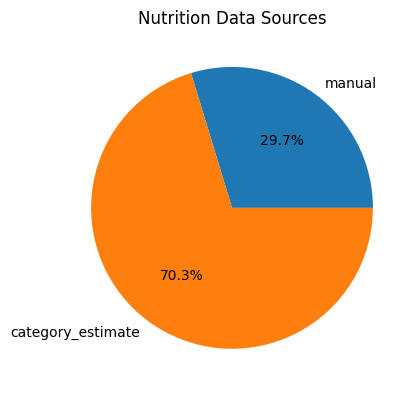

In [27]:
# Analyze sources of nutrition data
sources = {}
categories = {}

for food, data in nutrition_db.items():
    # Track sources
    source = data.get('source', 'unknown')
    if source not in sources:
        sources[source] = 0
    sources[source] += 1
    
    # Track categories for estimated data
    if source == 'category_estimate':
        category = data.get('category', 'unknown')
        if category not in categories:
            categories[category] = 0
        categories[category] += 1

# Plot sources distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie([v for v in sources.values()], labels=[k for k in sources.keys()], autopct='%1.1f%%')
plt.title('Nutrition Data Sources')

In [28]:
# Display sample entries
print("\nSample nutrition data:")
for food in unique_foods[:5]:  # First 5 foods
    print(f"{food}: {nutrition_db[food]}")

print("Nutrition database creation complete!")


Sample nutrition data:
apple_pie: {'protein': 3.6, 'carbohydrates': 34.0, 'fat': 15.0, 'calories': 277, 'source': 'manual'}
baby_back_ribs: {'protein': 22.0, 'carbohydrates': 5.0, 'fat': 18.0, 'calories': 280, 'source': 'manual'}
baklava: {'protein': 6.0, 'carbohydrates': 40.0, 'fat': 25.0, 'calories': 403, 'source': 'manual'}
beef_carpaccio: {'protein': 28.0, 'carbohydrates': 0.5, 'fat': 14.0, 'calories': 245, 'source': 'manual'}
beef_tartare: {'protein': 20.0, 'carbohydrates': 1.0, 'fat': 15.0, 'calories': 220, 'source': 'manual'}
Nutrition database creation complete!
